In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['DGLBACKEND'] = 'tensorflow'

import pandas as pd
import numpy as np
import plotly.express as px
from tqdm.auto import tqdm
import os
from typing import Union, Literal
import sys
import dgl
import tensorflow as tf
import matplotlib.pyplot as plt

PROCESSED_DATA_PATH='../3_processed_data'
#chargement des dataframes 

base_ctc=pd.read_parquet(os.path.join(PROCESSED_DATA_PATH, 'customer_A.parquet')) #base client A sans pooling 
base_trs=pd.read_parquet(os.path.join(PROCESSED_DATA_PATH, 'transaction_A.parquet')) #transaction A sans pooling 
pooled_ctc=pd.read_parquet(os.path.join(PROCESSED_DATA_PATH, 'customer_A_pooled.parquet')) #base client A pooled 
pooled_trs=pd.read_parquet(os.path.join(PROCESSED_DATA_PATH, 'transaction_A_pooled.parquet')) #base client A pooled 

ModuleNotFoundError: No module named 'dgl'

In [2]:
#x : toutes les dates de transaction
x = base_trs['timestamp'].unique()
x.sort()
x

array(['2018-03-03', '2018-03-10', '2018-03-17', '2018-03-24',
       '2018-03-31', '2018-04-07', '2018-04-14', '2018-04-21',
       '2018-04-28', '2018-05-05', '2018-05-12', '2018-05-19',
       '2018-05-26', '2018-06-02', '2018-06-09', '2018-06-16',
       '2018-06-23', '2018-06-30', '2018-07-07', '2018-07-14',
       '2018-07-21', '2018-07-28', '2018-08-04', '2018-08-11',
       '2018-08-18', '2018-08-25', '2018-09-01', '2018-09-08',
       '2018-09-15', '2018-09-22', '2018-09-29', '2018-10-06',
       '2018-10-13', '2018-10-20', '2018-10-27', '2018-11-03',
       '2018-11-10', '2018-11-17', '2018-11-24', '2018-12-01',
       '2018-12-08', '2018-12-15', '2018-12-22', '2018-12-29',
       '2019-01-05', '2019-01-12', '2019-01-19', '2019-01-26',
       '2019-02-02', '2019-02-09', '2019-02-16', '2019-02-23',
       '2019-03-02', '2019-03-09', '2019-03-16', '2019-03-23',
       '2019-03-30', '2019-04-06', '2019-04-13', '2019-04-20',
       '2019-04-27', '2019-05-04', '2019-05-11', '2019-

In [3]:
#count transaction where sender OR receiver is from bank A on non pooled dataframes
((base_trs['sender_bank_id'] == 'A')|(base_trs['receiver_bank_id'] == 'A')).sum()

837981

In [4]:
#count transaction where sender OR receiver is from bank A on pooled dataframes
((pooled_trs['sender_bank_id'] == 'A')|(pooled_trs['receiver_bank_id'] == 'A')).sum()

837981

In [5]:
def to_dgl_graph(trs, ctc, label_field='is_alert_solo'):
    #trs : base transaction 
    #ctc : base client 
    ## Reindexation
    n_trs, n_ctc=trs.shape[0], ctc.shape[0]
    node_index = dict(zip(trs['transaction_global_id'].values, np.array(list(range(n_trs)))))
    node_index.update(dict(zip(ctc['global_id'].values, n_trs + np.array(list(range(n_ctc))))))
    
    trs['transaction_global_id']=trs['transaction_global_id'].apply(lambda x:node_index[x])
    trs['sender_global_id']=trs['sender_global_id'].apply(lambda x:node_index[x])
    trs['receiver_global_id']=trs['receiver_global_id'].apply(lambda x:node_index[x])
    
    trs['right_bank_id']= ((trs['sender_bank_id']=='A')|(trs['receiver_bank_id']=='A'))
    ctc['right_bank_id']= (ctc['bank_id']!='D')
    
    rate = 0.02 #trs[label_field].sum()/trs[label_field].shape[0]
    trs['sample_weights']=trs[label_field].apply(lambda x : 1-rate if x else rate)
    trs[trs['right_bank_id']==False]['sample_weights']=0
    
    ## Labels and masks
    ctc['is_alert_solo'], ctc['is_alert_pooled'], ctc['timestamp'], ctc['sample_weights']=0, 0, '1100-01-01', 0 
    labels=np.concatenate([trs[label_field].values, ctc[label_field].values])
    sample_weights=np.concatenate([trs['sample_weights'].values, ctc['sample_weights'].values])
    mask = np.concatenate([trs['timestamp'].values, ctc['timestamp'].values])
    
    A_mask=np.concatenate([trs['right_bank_id'].values, ctc['right_bank_id'].values])
    for i, elt in enumerate(A_mask):
        if not(elt):
            mask[i]='1000-01-01'
            
#     mask[A_mask]='1000-01-01'
    
    test_date="2021-06-01"
    ctc_mask=mask<='1000-01-01'
    
    train_mask = tf.constant((mask<test_date)&(mask>='1000-01-01'), dtype=bool)
#     train_mask = tf.constant((mask<'2222-22-22')&(mask>='1000-01-01'), dtype=bool)
    test_mask = tf.constant((mask>=test_date), dtype=bool)
    val_mask = tf.constant((mask>=test_date), dtype=bool)
    
#     train_mask = train_mask | test_mask
    sample_weights[test_mask]=0
    ## Features
    trs_features=trs[['tx_amount', 'timestamp', 'tx_type']].copy()
    ctc_features=ctc[['global_id', 'country_code', 'bank_id']].copy()
    
    # trs_features
    trs_features['month'] = trs_features['timestamp'].apply(lambda x : int(x.split('-')[1]))
    
    tx_type=dict(zip(trs_features['tx_type'].unique(), range(trs_features['tx_type'].nunique())))
    trs_features['tx_type'] = trs_features['tx_type'].apply(lambda x : tx_type[x])
    trs_features['tx_amount'] = trs_features['tx_amount'].apply(lambda x: np.log(1+x)*5//1)
    trs_features=trs_features[['tx_amount', 'month', 'tx_type']].values
     
    # ctc_features
    country_code=dict(zip(ctc_features['country_code'].unique(), range(ctc_features['country_code'].nunique()+1)))
#     print(country_code)
    bank_id=dict(zip(ctc_features['bank_id'].unique(), range(ctc_features['bank_id'].nunique()+1)))
    ctc_id=dict(zip(ctc_features['global_id'].unique(), range(ctc_features['global_id'].nunique()+1)))
    ctc_features['country_code'] = ctc_features['country_code'].apply(lambda x : country_code[x])
    ctc_features['bank_id'] = ctc_features['bank_id'].apply(lambda x : bank_id[x])
    ctc_features['global_id'] = ctc_features['global_id'].apply(lambda x : ctc_id[x])
    ctc_features=ctc_features[[
        'global_id',
        'country_code', 
        'bank_id'
    ]].values
    
    
    src_edges=np.concatenate([ #source
        trs['sender_global_id'].values,
        trs['transaction_global_id'].values,
        trs['receiver_global_id'].values,
        trs['transaction_global_id'].values,
    ])
    
    tar_edges=np.concatenate([ #target
        trs['transaction_global_id'].values,
        trs['receiver_global_id'].values,
        trs['transaction_global_id'].values,
        trs['sender_global_id'].values,
    ])
#     print(tf.constant(tar_edges, dtype=tf.int32))
    g = dgl.graph((tf.constant(src_edges, dtype=tf.int32),tf.constant(tar_edges, dtype=tf.int32))) #tf.constant : tensor
    g.ndata['train_mask'], g.ndata['val_mask'], g.ndata['test_mask'] = train_mask, val_mask, test_mask #g.ndata défini à l'échelle du graph en entier ? 
    g.ndata['label']=tf.constant(labels, dtype=tf.int32)
    g.ndata['sample_weights']=tf.constant(sample_weights)
#     g.ndata['trc_features']=tf.constant(trs_features, dtype=tf.int32)
#     g.ndata['ctc_features']=tf.constant(ctc_features, dtype=tf.int32)
    return g, tf.constant(trs_features, dtype=tf.int32), tf.constant(ctc_features, dtype=tf.int32)

In [6]:
class SingleGraphModel(tf.keras.Model):
    def __init__(self
                ):
        '''Define here your graph and layers'''
        super(SingleGraphModel, self).__init__()
        pass
    
    def call(self, indices):
        '''Define here your operations'''
        pass
    
    def split_indices(self):
        '''Utils to split indices into train, val and test indices based on dgl graph content'''
        indices=np.arange(len(self.g.ndata['train_mask']))
        self.train_indices=indices[self.g.ndata['train_mask'].numpy()]
        self.val_indices=indices[self.g.ndata['val_mask'].numpy()]
        self.test_indices=indices[self.g.ndata['test_mask'].numpy()]
        return self.train_indices, self.val_indices, self.test_indices
    
    def batch_split(self, X, batch_size=1, do_shuffle=True):
        X_batch=X
        s=len(X_batch)-1
        if do_shuffle:
            np.random.shuffle(X_batch)
        return [X_batch[i*batch_size:(i+1)*batch_size] for i in range(s//batch_size + 1)]

#Batch splitting is the process of dividing a larger dataset or array of data into smaller, more manageable batches or subsets. 
#This technique is often used in machine learning and deep learning to efficiently train models on large datasets.
    
    def soft_compile(self, loss, optimizer, metrics={}, val_metrics={}):
        self.loss=loss
        self.optimizer=optimizer
        self.metrics_dict=metrics
        self.val_metrics_dict=val_metrics
    
    def make_history(self, inner=False):
        history={'loss':[]}
        history.update({metric:[] for metric in self.metrics_dict})
        if not(inner):
            history['lr']=[]
            history['val_loss']=[]
            history.update({'val_'+metric:[] for metric in self.metrics_dict})
        return history
#his is a method of a class that creates and returns a dictionary called "history" to keep track of the training and validation metrics of a neural network model during the training process. 
# The method takes an optional argument called "inner" which is set to False by default. 
# If "inner" is False, additional validation metrics will be added to the dictionary.
        
    def compute_metrics(self,true, pred, prefix=""):
        return {prefix+metric:np.round(self.metrics_dict[metric](true,pred).numpy(), 4) for metric in self.metrics_dict}
    
    def compute_val_metrics(self,true, pred, prefix=""):
        return {prefix+metric:np.round(self.val_metrics_dict[metric](true,pred).numpy(), 4) for metric in self.val_metrics_dict}
    
    def update_history(self, history, new_values):
        for value in new_values:
            history[value].append(new_values[value])
        return history
    
    def has_improved(self, history, quantity='loss', direction='min', margin=0, patience=10, ratio=0, min_lr=0):
        check_array=np.array(history[quantity])
        if len(check_array) <= patience:
            return True
        check_array=check_array[-patience:]
        
        if direction=='min':
            if check_array[0] - margin < np.min(check_array):
                return False
        if direction=='max':
            if check_array[0] + margin > np.max(check_array):
                return False
        return True
    
    def train(self, epochs, batch_size, reduce_lr=None, early_stopping=None):
        train_indices, val_indices, test_indices=self.split_indices()
        labels=self.g.ndata['label'].numpy()
        sample_weights=self.g.ndata['sample_weights'].numpy() #c quoi sample_weight ? 
        
        history=self.make_history()
        epoch_iterator=tqdm(range(epochs))
        
        reduce_lr_count=0
        
        for epoch in epoch_iterator:
            reduce_lr_count+=1
            # Update
            batch_history=self.make_history(inner=True)
            batch_iterator=tqdm(self.batch_split(train_indices, batch_size=batch_size, do_shuffle=True), desc=f"Epoch {epoch}", leave=False)
#batch_iterator is a loop that iterates through mini-batches of data during training. 
#It is created by splitting the training indices into batches of size batch_size using the batch_split function.
 
            for batch in batch_iterator:
#                 print(batch)
#This block of code is the main training loop of a model, where the model is being trained on the training data in batches of a specified size.

                with tf.GradientTape() as tape:    
                    logits=self.call(batch)
                    weights=sample_weights[batch]
                    weights=weights/tf.reduce_sum(weights)
                    loss=self.loss(labels[batch], logits) * tf.cast(weights, dtype=tf.float32)
                    loss=10*tf.reduce_sum(loss)
#                     loss=self.loss(labels[batch], logits)
#                     loss=tf.reduce_mean(loss)
                    metrics=self.compute_metrics(labels[batch], logits)
                    metrics['loss']=loss.numpy()
                    grads = tape.gradient(loss, self.trainable_weights)
                    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
                batch_history=self.update_history(batch_history, metrics)
                averaged_batch_history={metric:np.round(np.mean(batch_history[metric]), 4) for metric in batch_history}
                batch_iterator.set_postfix_str(str(averaged_batch_history))
                
            # Validation
            averaged_batch_history['lr']=self.optimizer.learning_rate.numpy()
            val_logits=self.call(val_indices)
            averaged_batch_history['val_loss']=tf.reduce_sum(self.loss(labels[val_indices], val_logits)).numpy()
            val_metrics=self.compute_val_metrics(labels[val_indices], val_logits, prefix='val_')
            averaged_batch_history.update(val_metrics)
            print(f"Epoch {epoch} : " + str(averaged_batch_history))
            
            history = self.update_history(history, averaged_batch_history)
            # Callbacks
            #This callback reduces the learning rate of the optimizer when the training performance of the model plateaus.
            #It takes a few arguments: patience (number of epochs with no improvement after which learning rate will be reduced), min_lr (minimum learning rate to be reached), and ratio (factor by which the learning rate will be reduced).
            if reduce_lr:
                has_improved=self.has_improved(history, **reduce_lr)
                if not(has_improved) and reduce_lr_count>=reduce_lr['patience']:
                    lr=self.optimizer.learning_rate.numpy()
                    if lr >= reduce_lr['min_lr'] * reduce_lr['ratio']:
                        print(f"Reducing learning rate from {lr} to {lr * reduce_lr['ratio']}")
                        self.optimizer = tf.keras.optimizers.Adam(lr * reduce_lr['ratio'])
                        reduce_lr_count=0
             
            if early_stopping:
                has_improved=self.has_improved(history, **early_stopping)
                if not(has_improved):
                    print("***************************************************************************")
                    break        
        return history    

In [7]:
from dgl.nn.tensorflow import GraphConv, GATConv

class CatEncoder(tf.keras.Model):
    def __init__(self, feature_set, d_model):
        super(CatEncoder, self).__init__()
        self.feature_set=feature_set
        self.n_features=self.feature_set.shape[1]
        self.embedding_layers=[tf.keras.layers.Embedding(np.max(feature_set[:,i])+1, d_model) for i in range(self.n_features)]
        
    def call(self, x):
        encoded_features=[self.embedding_layers[i](self.feature_set[:,i]) for i in range(self.n_features)]
        return tf.reduce_sum(encoded_features, axis=0)

#Embedding is a technique to represent categorical variables as continuous vectors in a high-dimensional space. 
#Mapping from discrete categorical variables to continuous vectors.
#The result of summing the embedded features is a tensor of shape (batch_size, d_model), 
# where batch_size is the number of samples in the batch, and d_model is the dimensionality of the embedding space. 
# This tensor represents the encoded features for the categorical variables.
    
class AttentionBlock(tf.keras.Model):
    def __init__(self,in_feats, out_feats, num_heads, feat_drop=0.0, attn_drop=0.0, negative_slope=0.2, residual=False, activation=None, allow_zero_in_degree=False):
        super(AttentionBlock, self).__init__()
        self.gat_conv=GATConv(in_feats, out_feats, num_heads, feat_drop, attn_drop, negative_slope, residual, activation, allow_zero_in_degree)
        self.reshape=tf.keras.layers.Reshape((out_feats*num_heads,))
        self.out=tf.keras.layers.Dense(out_feats, activation='relu')
        
    def call(self, g, x):
        y=self.gat_conv(g, x)
        y=self.reshape(y)
        y=self.out(y)
        return y

#The GAT block takes as input a graph g and a node feature tensor x, and applies a graph attention layer using the GATConv class. 
#The graph attention layer outputs a new node feature tensor y.
#A node feature tensor is a data structure that stores information associated with each node in a graph. 
#In machine learning applications, node feature tensors are commonly used to represent the attributes or properties of each node in a graph.

#In the context of graph neural networks, each node in a graph is associated with a feature vector that encodes the relevant information about the node. 
#The feature vector can contain a wide variety of information, such as text, image, or numerical data, depending on the specific application. 
#Node feature tensors are typically represented as a matrix, where each row corresponds to a node in the graph and each column corresponds to a feature dimension. 
#The values in the matrix represent the feature values associated with each node.


#The reshape layer is then used to reshape y from a 3D tensor of shape (batch_size, num_nodes, out_feats*num_heads) to a 2D tensor of shape (batch_size, out_feats*num_heads).

#Finally, the out layer applies a fully-connected layer to map the feature tensor to a new feature space, which is then passed as output.

#The parameters of the AttentionBlock are:

#in_feats: the number of input node features.
#out_feats: the number of output node features.
#num_heads: the number of attention heads.
#feat_drop: the dropout rate applied to the input features.
#attn_drop: the dropout rate applied to the attention coefficients.
#negative_slope: the negative slope of the LeakyReLU activation function used in the GATConv layer.
#residual: whether to use residual connection or not.
#activation: the activation function applied to the output features.
#allow_zero_in_degree: whether to allow nodes with zero in-degree in the graph.
    
class GCN_ACPR(SingleGraphModel):
    def __init__(self, g,trs_features, ctc_features, d_model, dff, n_layers, class_num):
        super(GCN_ACPR, self).__init__()
        self.g = g
        self.trs_features=CatEncoder(trs_features, d_model)
        self.ctc_features=CatEncoder(ctc_features, d_model)
        self.embedding=tf.keras.layers.Dense(d_model, activation='relu')
        
#         self.gcn_layers=[GraphConv(d_model, d_model, activation=tf.nn.relu, allow_zero_in_degree=True) for _ in range(n_layers)]
#         self.gcn_layers=[AttentionBlock(d_model, d_model, num_heads=num_heads, activation=tf.nn.relu,residual=False, allow_zero_in_degree=True) for _ in range(n_layers)]
        self.classifier = tf.keras.layers.Dense(class_num, activation='sigmoid')
    
    def call(self, indices, training=True):
        hidden_states = tf.concat(
            [
                self.trs_features(0),
                self.ctc_features(0)
            ], axis = 0
        )
        hidden_states = self.embedding(hidden_states)
#         for layer in self.gcn_layers:
#             hidden_states += layer(self.g, hidden_states, training=training)
        logits = self.classifier(hidden_states)
        return tf.gather(logits, indices)[:,0]

#This code defines a graph neural network model named GCN_ACPR that inherits from the SingleGraphModel class. 
#The model takes as input a graph (g), and two sets of categorical features (trs_features and ctc_features) that are passed through a CatEncoder class to obtain their embeddings. 
#The embeddings of the two sets of features are concatenated and passed through a Dense layer with a relu activation function to get the initial hidden states of the nodes.

#Next, the hidden states are passed through a stack of graph convolutional layers (which are commented out in the code) or attention blocks (AttentionBlock). 
#Finally, the output of the last layer is passed through a Dense layer with a sigmoid activation function to obtain the predicted probability for 
#each node belonging to a specific class. The call method takes an argument indices, which represents the indices of the nodes for which the output is required. 
#These nodes are selected from the output logits tensor using the tf.gather method.

## Dataset Label

In [8]:
d_model= 32
n_layers = 2
n_classes = 1
num_heads=4
dff=64

epochs=400
batch_size=16384*2


reduce_lr={
    'quantity':'val_auc',
    'direction' : 'max',
    'margin':0.001,
    'patience':4,
    'ratio':0.1,
    'min_lr':1e-6
}

early_stopping={
    'quantity':'val_auc',
    'direction' : 'max',
    'margin':0.001,
    'patience':9
}


## Solo Solo

In [9]:
g, trs_features, ctc_features = to_dgl_graph(base_trs.copy(), base_ctc.copy(), label_field='is_alert_solo')

In [10]:
# g = dataset[0]

model_solo_solo = GCN_ACPR(g, trs_features, ctc_features, d_model, dff, n_layers, n_classes)
# model = GAT(g, d_maodel, n_layers, n_classes, num_heads)

model_solo_solo.soft_compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none'),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='none'),
    optimizer=tf.keras.optimizers.Adam(0.01),#, 1e-8),
#     metrics={'accuracy':tf.keras.metrics.SparseCategoricalAccuracy()}
    metrics={'accuracy':tf.keras.metrics.BinaryAccuracy(),
             'auc' : tf.keras.metrics.AUC(),
             'precision' : tf.keras.metrics.Precision(),
             'recall' : tf.keras.metrics.Recall(),
            },
    val_metrics={'accuracy':tf.keras.metrics.BinaryAccuracy(),
             'auc' : tf.keras.metrics.AUC(),
             'precision' : tf.keras.metrics.Precision(),
             'recall' : tf.keras.metrics.Recall(),
            }
)

In [11]:
graph_history_solo_solo = model_solo_solo.train(epochs=epochs,batch_size=batch_size, reduce_lr=reduce_lr, early_stopping=early_stopping)

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 0 : {'loss': 1.8675, 'accuracy': 0.8633, 'auc': 0.5022, 'precision': 0.0067, 'recall': 0.1355, 'lr': 0.01, 'val_loss': 0.06526256, 'val_accuracy': 0.9937, 'val_auc': 0.5155, 'val_precision': 0.0, 'val_recall': 0.0}


Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1 : {'loss': 0.5529, 'accuracy': 0.9697, 'auc': 0.5058, 'precision': 0.007, 'recall': 0.0263, 'lr': 0.01, 'val_loss': 0.037818637, 'val_accuracy': 0.9937, 'val_auc': 0.5319, 'val_precision': 0.5102, 'val_recall': 0.0156}


Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2 : {'loss': 0.4029, 'accuracy': 0.9794, 'auc': 0.5137, 'precision': 0.0106, 'recall': 0.0233, 'lr': 0.01, 'val_loss': 0.03758493, 'val_accuracy': 0.9937, 'val_auc': 0.5355, 'val_precision': 0.5102, 'val_recall': 0.0208}


Epoch 3:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3 : {'loss': 0.3755, 'accuracy': 0.9834, 'auc': 0.5224, 'precision': 0.0151, 'recall': 0.0241, 'lr': 0.01, 'val_loss': 0.03755763, 'val_accuracy': 0.9937, 'val_auc': 0.5335, 'val_precision': 0.5102, 'val_recall': 0.0234}


Epoch 4:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4 : {'loss': 0.4034, 'accuracy': 0.9857, 'auc': 0.5275, 'precision': 0.0195, 'recall': 0.0246, 'lr': 0.01, 'val_loss': 0.03755282, 'val_accuracy': 0.9937, 'val_auc': 0.5334, 'val_precision': 0.5102, 'val_recall': 0.0249}


Epoch 5:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5 : {'loss': 0.3745, 'accuracy': 0.9871, 'auc': 0.5302, 'precision': 0.0238, 'recall': 0.0248, 'lr': 0.01, 'val_loss': 0.037557893, 'val_accuracy': 0.9937, 'val_auc': 0.5373, 'val_precision': 0.5082, 'val_recall': 0.0258}


Epoch 6:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6 : {'loss': 0.3747, 'accuracy': 0.9881, 'auc': 0.5335, 'precision': 0.0281, 'recall': 0.025, 'lr': 0.01, 'val_loss': 0.03753485, 'val_accuracy': 0.9937, 'val_auc': 0.5366, 'val_precision': 0.5068, 'val_recall': 0.0264}


Epoch 7:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7 : {'loss': 0.3841, 'accuracy': 0.9888, 'auc': 0.5353, 'precision': 0.0319, 'recall': 0.0248, 'lr': 0.01, 'val_loss': 0.037561323, 'val_accuracy': 0.9937, 'val_auc': 0.5358, 'val_precision': 0.5045, 'val_recall': 0.0265}


Epoch 8:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8 : {'loss': 0.3839, 'accuracy': 0.9894, 'auc': 0.5365, 'precision': 0.0356, 'recall': 0.0246, 'lr': 0.01, 'val_loss': 0.03754641, 'val_accuracy': 0.9937, 'val_auc': 0.5359, 'val_precision': 0.5026, 'val_recall': 0.0266}
Reducing learning rate from 0.009999999776482582 to 0.0009999999776482583


Epoch 9:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9 : {'loss': 0.3931, 'accuracy': 0.9898, 'auc': 0.5372, 'precision': 0.0394, 'recall': 0.0245, 'lr': 0.0009999999776482583, 'val_loss': 0.037538428, 'val_accuracy': 0.9937, 'val_auc': 0.5354, 'val_precision': 0.5035, 'val_recall': 0.0271}


Epoch 10:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10 : {'loss': 0.4184, 'accuracy': 0.9901, 'auc': 0.5377, 'precision': 0.0433, 'recall': 0.0246, 'lr': 0.0009999999776482583, 'val_loss': 0.037535124, 'val_accuracy': 0.9937, 'val_auc': 0.5348, 'val_precision': 0.5042, 'val_recall': 0.0273}


Epoch 11:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11 : {'loss': 0.4051, 'accuracy': 0.9904, 'auc': 0.5384, 'precision': 0.0471, 'recall': 0.0246, 'lr': 0.0009999999776482583, 'val_loss': 0.03756266, 'val_accuracy': 0.9937, 'val_auc': 0.5346, 'val_precision': 0.5048, 'val_recall': 0.0275}


Epoch 12:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12 : {'loss': 0.3833, 'accuracy': 0.9906, 'auc': 0.5388, 'precision': 0.0509, 'recall': 0.0247, 'lr': 0.0009999999776482583, 'val_loss': 0.037542425, 'val_accuracy': 0.9937, 'val_auc': 0.5347, 'val_precision': 0.5052, 'val_recall': 0.0277}
Reducing learning rate from 0.0009999999776482583 to 9.999999776482583e-05


Epoch 13:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 13 : {'loss': 0.3826, 'accuracy': 0.9908, 'auc': 0.5392, 'precision': 0.0547, 'recall': 0.0248, 'lr': 9.999999776482583e-05, 'val_loss': 0.03754563, 'val_accuracy': 0.9937, 'val_auc': 0.5348, 'val_precision': 0.5057, 'val_recall': 0.0279}
***************************************************************************


In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

model = model_solo_solo

train_indices, val_indices, test_indices=model_solo_solo.split_indices()
labels=model.g.ndata['label'].numpy()
val_labels=labels[test_indices]
val_logits=model.call(np.arange(len(val_indices))).numpy()

precision, recall, thresholds = precision_recall_curve(val_labels, val_logits)
fpr, tpr, threshold = roc_curve(val_labels, val_logits)
roc_auc = metrics.auc(fpr, tpr)

f1_score = 2*precision*recall/(precision + recall)

ind=np.argmax(f1_score)

print({
    'roc_auc_score':roc_auc_score(val_labels, val_logits),
    'precision':precsion[ind],
    'recall':recall[ind],
    'f1_score':f1_score[ind],
})

index = np.arange(len(precision))
t = 0.9*recall.max()
min_index = index[recall >= t]
print({
    'max_recall':recall.max(),
    '90 max recall':t,
    'precision_at_recall':precision[min_index],
    'f1_at_recall':f1_score[min_index]
})

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
train_indices, val_indices, test_indices=model_solo_solo.split_indices()
labels=model_solo_solo.g.ndata['label'].numpy()

logits=model_solo_solo.call(np.arange(len(labels))).numpy()
val_labels=labels[test_indices]

# plt.hist(val_logits)
tf.keras.metrics.AUC()(val_labels, logits[test_indices])



<tf.Tensor: shape=(), dtype=float32, numpy=0.5351476>

## Solo Pooled

In [13]:
g, trs_features, ctc_features = to_dgl_graph(base_trs.copy(), base_ctc.copy(), label_field='is_alert_pooled')

In [14]:
g.ndata['train_mask'].numpy().sum(), g.ndata['val_mask'].numpy().sum()

(721117, 126641)

In [15]:
model_solo_pool = GCN_ACPR(g, trs_features, ctc_features, d_model, dff, n_layers, n_classes)
# model = GAT(g, d_model, n_layers, n_classes, num_heads)

model_solo_pool.soft_compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none'),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='none'),
    optimizer=tf.keras.optimizers.Adam(0.01, 1e-8),
#     metrics={'accuracy':tf.keras.metrics.SparseCategoricalAccuracy()}
    metrics={'accuracy':tf.keras.metrics.BinaryAccuracy(),
             'auc' : tf.keras.metrics.AUC(),
             'precision' : tf.keras.metrics.Precision(),
             'recall' : tf.keras.metrics.Recall(),
            },
    val_metrics={'accuracy':tf.keras.metrics.BinaryAccuracy(),
             'auc' : tf.keras.metrics.AUC(),
             'precision' : tf.keras.metrics.Precision(),
             'recall' : tf.keras.metrics.Recall(),
            }
)

graph_history_solo_pool = model_solo_pool.train(epochs=epochs,batch_size=batch_size, reduce_lr=reduce_lr, early_stopping=early_stopping)

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 0 : {'loss': 1.3934, 'accuracy': 0.8964, 'auc': 0.5854, 'precision': 0.0017, 'recall': 0.1152, 'lr': 0.01, 'val_loss': 0.0072310325, 'val_accuracy': 0.9991, 'val_auc': 0.7035, 'val_precision': 1.0, 'val_recall': 0.2675}


Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1 : {'loss': 0.0617, 'accuracy': 0.9803, 'auc': 0.6851, 'precision': 0.0097, 'recall': 0.1443, 'lr': 0.01, 'val_loss': 0.006020918, 'val_accuracy': 0.9991, 'val_auc': 0.7035, 'val_precision': 1.0, 'val_recall': 0.2898}


Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2 : {'loss': 0.055, 'accuracy': 0.988, 'auc': 0.7006, 'precision': 0.0209, 'recall': 0.1959, 'lr': 0.01, 'val_loss': 0.005561422, 'val_accuracy': 0.9991, 'val_auc': 0.7035, 'val_precision': 1.0, 'val_recall': 0.2972}


Epoch 3:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3 : {'loss': 0.0511, 'accuracy': 0.9912, 'auc': 0.7105, 'precision': 0.0319, 'recall': 0.2169, 'lr': 0.01, 'val_loss': 0.0053582694, 'val_accuracy': 0.9991, 'val_auc': 0.7035, 'val_precision': 1.0, 'val_recall': 0.301}


Epoch 4:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4 : {'loss': 0.0501, 'accuracy': 0.993, 'auc': 0.7223, 'precision': 0.0424, 'recall': 0.2282, 'lr': 0.01, 'val_loss': 0.0054416643, 'val_accuracy': 0.9991, 'val_auc': 0.7035, 'val_precision': 1.0, 'val_recall': 0.3032}
Reducing learning rate from 0.009999999776482582 to 0.0009999999776482583


Epoch 5:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5 : {'loss': 0.0512, 'accuracy': 0.9941, 'auc': 0.7407, 'precision': 0.0526, 'recall': 0.2345, 'lr': 0.0009999999776482583, 'val_loss': 0.005221523, 'val_accuracy': 0.9991, 'val_auc': 0.7201, 'val_precision': 1.0, 'val_recall': 0.3047}


Epoch 6:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6 : {'loss': 0.0493, 'accuracy': 0.9949, 'auc': 0.7597, 'precision': 0.0629, 'recall': 0.2399, 'lr': 0.0009999999776482583, 'val_loss': 0.0051132417, 'val_accuracy': 0.9991, 'val_auc': 0.7359, 'val_precision': 1.0, 'val_recall': 0.3057}


Epoch 7:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7 : {'loss': 0.0482, 'accuracy': 0.9955, 'auc': 0.7723, 'precision': 0.0725, 'recall': 0.2435, 'lr': 0.0009999999776482583, 'val_loss': 0.0050595202, 'val_accuracy': 0.9991, 'val_auc': 0.7512, 'val_precision': 1.0, 'val_recall': 0.3065}


Epoch 8:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8 : {'loss': 0.0476, 'accuracy': 0.9959, 'auc': 0.7836, 'precision': 0.0824, 'recall': 0.2462, 'lr': 0.0009999999776482583, 'val_loss': 0.005058179, 'val_accuracy': 0.9991, 'val_auc': 0.7572, 'val_precision': 1.0, 'val_recall': 0.3071}


Epoch 9:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9 : {'loss': 0.059, 'accuracy': 0.9962, 'auc': 0.792, 'precision': 0.0919, 'recall': 0.2485, 'lr': 0.0009999999776482583, 'val_loss': 0.0050459737, 'val_accuracy': 0.9991, 'val_auc': 0.7662, 'val_precision': 1.0, 'val_recall': 0.3076}


Epoch 10:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10 : {'loss': 0.0478, 'accuracy': 0.9965, 'auc': 0.8005, 'precision': 0.1008, 'recall': 0.2492, 'lr': 0.0009999999776482583, 'val_loss': 0.005046681, 'val_accuracy': 0.9991, 'val_auc': 0.7649, 'val_precision': 1.0, 'val_recall': 0.308}


Epoch 11:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11 : {'loss': 0.0477, 'accuracy': 0.9967, 'auc': 0.804, 'precision': 0.1102, 'recall': 0.2516, 'lr': 0.0009999999776482583, 'val_loss': 0.0050098663, 'val_accuracy': 0.9991, 'val_auc': 0.7708, 'val_precision': 1.0, 'val_recall': 0.3084}


Epoch 12:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12 : {'loss': 0.0515, 'accuracy': 0.9969, 'auc': 0.8087, 'precision': 0.1194, 'recall': 0.2529, 'lr': 0.0009999999776482583, 'val_loss': 0.005017671, 'val_accuracy': 0.9991, 'val_auc': 0.7732, 'val_precision': 1.0, 'val_recall': 0.3087}


Epoch 13:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 13 : {'loss': 0.0473, 'accuracy': 0.9971, 'auc': 0.8137, 'precision': 0.1282, 'recall': 0.2544, 'lr': 0.0009999999776482583, 'val_loss': 0.005040356, 'val_accuracy': 0.9991, 'val_auc': 0.7786, 'val_precision': 1.0, 'val_recall': 0.3089}


Epoch 14:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 14 : {'loss': 0.0474, 'accuracy': 0.9972, 'auc': 0.8176, 'precision': 0.1363, 'recall': 0.2546, 'lr': 0.0009999999776482583, 'val_loss': 0.0050352863, 'val_accuracy': 0.9991, 'val_auc': 0.783, 'val_precision': 1.0, 'val_recall': 0.3091}


Epoch 15:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 15 : {'loss': 0.0473, 'accuracy': 0.9973, 'auc': 0.8195, 'precision': 0.1447, 'recall': 0.2553, 'lr': 0.0009999999776482583, 'val_loss': 0.005025751, 'val_accuracy': 0.9991, 'val_auc': 0.7869, 'val_precision': 1.0, 'val_recall': 0.3093}


Epoch 16:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 16 : {'loss': 0.0472, 'accuracy': 0.9974, 'auc': 0.8225, 'precision': 0.1534, 'recall': 0.2568, 'lr': 0.0009999999776482583, 'val_loss': 0.005026328, 'val_accuracy': 0.9991, 'val_auc': 0.7902, 'val_precision': 1.0, 'val_recall': 0.3095}


Epoch 17:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 17 : {'loss': 0.0472, 'accuracy': 0.9975, 'auc': 0.825, 'precision': 0.1611, 'recall': 0.2567, 'lr': 0.0009999999776482583, 'val_loss': 0.0050233346, 'val_accuracy': 0.9991, 'val_auc': 0.7928, 'val_precision': 1.0, 'val_recall': 0.3096}


Epoch 18:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 18 : {'loss': 0.0574, 'accuracy': 0.9976, 'auc': 0.8283, 'precision': 0.1694, 'recall': 0.2577, 'lr': 0.0009999999776482583, 'val_loss': 0.005020824, 'val_accuracy': 0.9991, 'val_auc': 0.7954, 'val_precision': 1.0, 'val_recall': 0.3098}


Epoch 19:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 19 : {'loss': 0.0476, 'accuracy': 0.9977, 'auc': 0.8314, 'precision': 0.1769, 'recall': 0.2578, 'lr': 0.0009999999776482583, 'val_loss': 0.005078946, 'val_accuracy': 0.9991, 'val_auc': 0.7934, 'val_precision': 1.0, 'val_recall': 0.3099}


Epoch 20:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 20 : {'loss': 0.0475, 'accuracy': 0.9978, 'auc': 0.832, 'precision': 0.1846, 'recall': 0.2585, 'lr': 0.0009999999776482583, 'val_loss': 0.005058725, 'val_accuracy': 0.9991, 'val_auc': 0.7938, 'val_precision': 1.0, 'val_recall': 0.31}


Epoch 21:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 21 : {'loss': 0.0474, 'accuracy': 0.9978, 'auc': 0.8331, 'precision': 0.1921, 'recall': 0.259, 'lr': 0.0009999999776482583, 'val_loss': 0.0050462103, 'val_accuracy': 0.9991, 'val_auc': 0.7952, 'val_precision': 1.0, 'val_recall': 0.3101}
Reducing learning rate from 0.0009999999776482583 to 9.999999776482583e-05


Epoch 22:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 22 : {'loss': 0.0471, 'accuracy': 0.9979, 'auc': 0.8354, 'precision': 0.1994, 'recall': 0.2592, 'lr': 9.999999776482583e-05, 'val_loss': 0.005044147, 'val_accuracy': 0.9991, 'val_auc': 0.7956, 'val_precision': 1.0, 'val_recall': 0.3102}


Epoch 23:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 23 : {'loss': 0.0505, 'accuracy': 0.9979, 'auc': 0.8371, 'precision': 0.2066, 'recall': 0.2594, 'lr': 9.999999776482583e-05, 'val_loss': 0.005043137, 'val_accuracy': 0.9991, 'val_auc': 0.796, 'val_precision': 1.0, 'val_recall': 0.3102}


Epoch 24:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 24 : {'loss': 0.0474, 'accuracy': 0.998, 'auc': 0.8388, 'precision': 0.2139, 'recall': 0.2598, 'lr': 9.999999776482583e-05, 'val_loss': 0.0050417776, 'val_accuracy': 0.9991, 'val_auc': 0.7963, 'val_precision': 1.0, 'val_recall': 0.3103}


Epoch 25:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 25 : {'loss': 0.0472, 'accuracy': 0.998, 'auc': 0.8406, 'precision': 0.2207, 'recall': 0.2602, 'lr': 9.999999776482583e-05, 'val_loss': 0.005044804, 'val_accuracy': 0.9991, 'val_auc': 0.7967, 'val_precision': 1.0, 'val_recall': 0.3104}


Epoch 26:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 26 : {'loss': 0.0471, 'accuracy': 0.9981, 'auc': 0.8418, 'precision': 0.2276, 'recall': 0.2604, 'lr': 9.999999776482583e-05, 'val_loss': 0.0050416617, 'val_accuracy': 0.9991, 'val_auc': 0.797, 'val_precision': 1.0, 'val_recall': 0.3105}
Reducing learning rate from 9.999999776482583e-05 to 9.999999776482583e-06


Epoch 27:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 27 : {'loss': 0.0472, 'accuracy': 0.9981, 'auc': 0.8433, 'precision': 0.2344, 'recall': 0.2608, 'lr': 9.999999776482583e-06, 'val_loss': 0.0050416277, 'val_accuracy': 0.9991, 'val_auc': 0.7973, 'val_precision': 1.0, 'val_recall': 0.3105}


Epoch 28:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 28 : {'loss': 0.0471, 'accuracy': 0.9981, 'auc': 0.8445, 'precision': 0.241, 'recall': 0.2609, 'lr': 9.999999776482583e-06, 'val_loss': 0.0050415527, 'val_accuracy': 0.9991, 'val_auc': 0.7975, 'val_precision': 1.0, 'val_recall': 0.3106}


Epoch 29:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 29 : {'loss': 0.0471, 'accuracy': 0.9982, 'auc': 0.8457, 'precision': 0.2474, 'recall': 0.2611, 'lr': 9.999999776482583e-06, 'val_loss': 0.0050414465, 'val_accuracy': 0.9991, 'val_auc': 0.7978, 'val_precision': 1.0, 'val_recall': 0.3106}


Epoch 30:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 30 : {'loss': 0.0474, 'accuracy': 0.9982, 'auc': 0.8466, 'precision': 0.2535, 'recall': 0.2609, 'lr': 9.999999776482583e-06, 'val_loss': 0.005041256, 'val_accuracy': 0.9991, 'val_auc': 0.798, 'val_precision': 1.0, 'val_recall': 0.3107}
Reducing learning rate from 9.999999776482583e-06 to 9.999999776482584e-07


Epoch 31:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 31 : {'loss': 0.0471, 'accuracy': 0.9982, 'auc': 0.8478, 'precision': 0.2601, 'recall': 0.2615, 'lr': 9.999999776482584e-07, 'val_loss': 0.005041162, 'val_accuracy': 0.9991, 'val_auc': 0.7982, 'val_precision': 1.0, 'val_recall': 0.3107}


Epoch 32:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 32 : {'loss': 0.0474, 'accuracy': 0.9983, 'auc': 0.8488, 'precision': 0.2662, 'recall': 0.2617, 'lr': 9.999999776482584e-07, 'val_loss': 0.00504118, 'val_accuracy': 0.9991, 'val_auc': 0.7984, 'val_precision': 1.0, 'val_recall': 0.3108}


Epoch 33:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 33 : {'loss': 0.0471, 'accuracy': 0.9983, 'auc': 0.8497, 'precision': 0.2723, 'recall': 0.2618, 'lr': 9.999999776482584e-07, 'val_loss': 0.005041157, 'val_accuracy': 0.9991, 'val_auc': 0.7986, 'val_precision': 1.0, 'val_recall': 0.3108}


Epoch 34:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 34 : {'loss': 0.051, 'accuracy': 0.9983, 'auc': 0.8506, 'precision': 0.2783, 'recall': 0.262, 'lr': 9.999999776482584e-07, 'val_loss': 0.0050411527, 'val_accuracy': 0.9991, 'val_auc': 0.7988, 'val_precision': 1.0, 'val_recall': 0.3108}
Reducing learning rate from 9.999999776482584e-07 to 9.999999776482584e-08


Epoch 35:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 35 : {'loss': 0.047, 'accuracy': 0.9983, 'auc': 0.8513, 'precision': 0.2842, 'recall': 0.2621, 'lr': 9.999999776482584e-08, 'val_loss': 0.0050411453, 'val_accuracy': 0.9991, 'val_auc': 0.799, 'val_precision': 1.0, 'val_recall': 0.3109}


Epoch 36:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 36 : {'loss': 0.047, 'accuracy': 0.9984, 'auc': 0.8523, 'precision': 0.29, 'recall': 0.2624, 'lr': 9.999999776482584e-08, 'val_loss': 0.005041144, 'val_accuracy': 0.9991, 'val_auc': 0.7991, 'val_precision': 1.0, 'val_recall': 0.3109}


Epoch 37:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 37 : {'loss': 0.047, 'accuracy': 0.9984, 'auc': 0.853, 'precision': 0.2959, 'recall': 0.2627, 'lr': 9.999999776482584e-08, 'val_loss': 0.0050411453, 'val_accuracy': 0.9991, 'val_auc': 0.7993, 'val_precision': 1.0, 'val_recall': 0.3109}


Epoch 38:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 38 : {'loss': 0.0471, 'accuracy': 0.9984, 'auc': 0.8535, 'precision': 0.3012, 'recall': 0.2626, 'lr': 9.999999776482584e-08, 'val_loss': 0.0050411425, 'val_accuracy': 0.9991, 'val_auc': 0.7994, 'val_precision': 1.0, 'val_recall': 0.311}


Epoch 39:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 39 : {'loss': 0.0472, 'accuracy': 0.9984, 'auc': 0.8542, 'precision': 0.3068, 'recall': 0.2627, 'lr': 9.999999776482584e-08, 'val_loss': 0.005041142, 'val_accuracy': 0.9991, 'val_auc': 0.7996, 'val_precision': 1.0, 'val_recall': 0.311}


Epoch 40:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 40 : {'loss': 0.0624, 'accuracy': 0.9984, 'auc': 0.8548, 'precision': 0.312, 'recall': 0.2627, 'lr': 9.999999776482584e-08, 'val_loss': 0.0050411415, 'val_accuracy': 0.9991, 'val_auc': 0.7997, 'val_precision': 1.0, 'val_recall': 0.311}


Epoch 41:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 41 : {'loss': 0.0473, 'accuracy': 0.9984, 'auc': 0.8554, 'precision': 0.3174, 'recall': 0.2628, 'lr': 9.999999776482584e-08, 'val_loss': 0.005041129, 'val_accuracy': 0.9991, 'val_auc': 0.7998, 'val_precision': 1.0, 'val_recall': 0.311}


Epoch 42:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 42 : {'loss': 0.0576, 'accuracy': 0.9985, 'auc': 0.856, 'precision': 0.3227, 'recall': 0.2629, 'lr': 9.999999776482584e-08, 'val_loss': 0.005041124, 'val_accuracy': 0.9991, 'val_auc': 0.7999, 'val_precision': 1.0, 'val_recall': 0.3111}


Epoch 43:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 43 : {'loss': 0.0471, 'accuracy': 0.9985, 'auc': 0.8566, 'precision': 0.328, 'recall': 0.2632, 'lr': 9.999999776482584e-08, 'val_loss': 0.0050411182, 'val_accuracy': 0.9991, 'val_auc': 0.8001, 'val_precision': 1.0, 'val_recall': 0.3111}


Epoch 44:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 44 : {'loss': 0.0519, 'accuracy': 0.9985, 'auc': 0.8571, 'precision': 0.3331, 'recall': 0.2633, 'lr': 9.999999776482584e-08, 'val_loss': 0.0050411136, 'val_accuracy': 0.9991, 'val_auc': 0.8002, 'val_precision': 1.0, 'val_recall': 0.3111}


Epoch 45:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 45 : {'loss': 0.0476, 'accuracy': 0.9985, 'auc': 0.8576, 'precision': 0.3381, 'recall': 0.2634, 'lr': 9.999999776482584e-08, 'val_loss': 0.005041107, 'val_accuracy': 0.9991, 'val_auc': 0.8003, 'val_precision': 1.0, 'val_recall': 0.3111}
***************************************************************************


In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

model = model_solo_pool

train_indices, val_indices, test_indices=model_solo_solo.split_indices()
labels=model.g.ndata['label'].numpy()
val_labels=labels[test_indices]
val_logits=model.call(np.arange(len(val_indices))).numpy()

precision, recall, thresholds = precision_recall_curve(val_labels, val_logits)
fpr, tpr, threshold = roc_curve(val_labels, val_logits)
roc_auc = metrics.auc(fpr, tpr)

f1_score = 2*precision*recall/(precision + recall)

ind=np.argmax(f1_score)

print({
    'roc_auc_score':roc_auc_score(val_labels, val_logits),
    'precision':precsion[ind],
    'recall':recall[ind],
    'f1_score':f1_score[ind],
})

index = np.arange(len(precision))
t = 0.9*recall.max()
min_index = index[recall >= t]
print({
    'max_recall':recall.max(),
    '90 max recall':t,
    'precision_at_recall':precision[min_index],
    'f1_at_recall':f1_score[min_index]
})

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

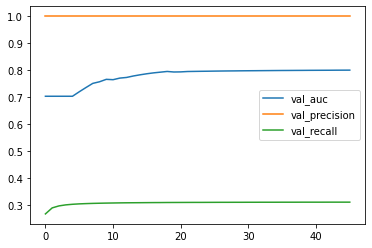

In [16]:
plt.plot(graph_history_solo_pool['val_auc'])
plt.plot(graph_history_solo_pool['val_precision'])
plt.plot(graph_history_solo_pool['val_recall'])
plt.legend(['val_auc', 'val_precision', 'val_recall'])

## Pooled Solo

In [17]:
g, trs_features, ctc_features = to_dgl_graph(pooled_trs.copy(), pooled_ctc.copy(), label_field='is_alert_solo')

C:\Users\GABRIE~1.OLY\AppData\Local\Temp/ipykernel_17372/2726447313.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trs[trs['right_bank_id']==False]['sample_weights']=0


In [18]:
g.ndata['train_mask'].numpy().sum(), g.ndata['val_mask'].numpy().sum()

(966718, 126641)

In [19]:
model_pool_solo = GCN_ACPR(g, trs_features, ctc_features, d_model, dff, n_layers, n_classes)
# model = GAT(g, d_model, n_layers, n_classes, num_heads)

model_pool_solo.soft_compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none'),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='none'),
    optimizer=tf.keras.optimizers.Adam(0.01, 1e-8),
#     metrics={'accuracy':tf.keras.metrics.SparseCategoricalAccuracy()}
    metrics={'accuracy':tf.keras.metrics.BinaryAccuracy(),
             'auc' : tf.keras.metrics.AUC(),
             'precision' : tf.keras.metrics.Precision(),
             'recall' : tf.keras.metrics.Recall(),
            },
    val_metrics={'accuracy':tf.keras.metrics.BinaryAccuracy(),
             'auc' : tf.keras.metrics.AUC(),
             'precision' : tf.keras.metrics.Precision(),
             'recall' : tf.keras.metrics.Recall(),
            }
)

graph_history_pool_solo = model_pool_solo.train(epochs=epochs,batch_size=batch_size, reduce_lr=reduce_lr, early_stopping=early_stopping)

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 : {'loss': 0.9977, 'accuracy': 0.9885, 'auc': 0.5097, 'precision': 0.0082, 'recall': 0.0048, 'lr': 0.01, 'val_loss': 0.037506364, 'val_accuracy': 0.9937, 'val_auc': 0.5246, 'val_precision': 0.7333, 'val_recall': 0.0137}


Epoch 1:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 : {'loss': 0.3847, 'accuracy': 0.9926, 'auc': 0.5254, 'precision': 0.0616, 'recall': 0.0087, 'lr': 0.01, 'val_loss': 0.037487682, 'val_accuracy': 0.9937, 'val_auc': 0.5283, 'val_precision': 0.5625, 'val_recall': 0.0224}


Epoch 2:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2 : {'loss': 0.3834, 'accuracy': 0.993, 'auc': 0.5308, 'precision': 0.1498, 'recall': 0.0159, 'lr': 0.01, 'val_loss': 0.037510995, 'val_accuracy': 0.9937, 'val_auc': 0.5345, 'val_precision': 0.5398, 'val_recall': 0.0254}


Epoch 3:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3 : {'loss': 0.3847, 'accuracy': 0.9931, 'auc': 0.5345, 'precision': 0.2128, 'recall': 0.0195, 'lr': 0.01, 'val_loss': 0.037573714, 'val_accuracy': 0.9937, 'val_auc': 0.5348, 'val_precision': 0.5309, 'val_recall': 0.0268}


Epoch 4:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4 : {'loss': 0.3845, 'accuracy': 0.9932, 'auc': 0.537, 'precision': 0.2574, 'recall': 0.0214, 'lr': 0.01, 'val_loss': 0.037539214, 'val_accuracy': 0.9937, 'val_auc': 0.5353, 'val_precision': 0.5286, 'val_recall': 0.0277}


Epoch 5:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5 : {'loss': 0.3842, 'accuracy': 0.9932, 'auc': 0.5386, 'precision': 0.2927, 'recall': 0.0228, 'lr': 0.01, 'val_loss': 0.037547346, 'val_accuracy': 0.9937, 'val_auc': 0.5353, 'val_precision': 0.5398, 'val_recall': 0.0254}
Reducing learning rate from 0.009999999776482582 to 0.0009999999776482583


Epoch 6:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6 : {'loss': 0.3834, 'accuracy': 0.9933, 'auc': 0.5399, 'precision': 0.3081, 'recall': 0.022, 'lr': 0.0009999999776482583, 'val_loss': 0.037505914, 'val_accuracy': 0.9937, 'val_auc': 0.5358, 'val_precision': 0.5603, 'val_recall': 0.0257}


Epoch 7:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7 : {'loss': 0.3837, 'accuracy': 0.9933, 'auc': 0.5407, 'precision': 0.3258, 'recall': 0.0216, 'lr': 0.0009999999776482583, 'val_loss': 0.037514303, 'val_accuracy': 0.9937, 'val_auc': 0.5355, 'val_precision': 0.5578, 'val_recall': 0.0263}


Epoch 8:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8 : {'loss': 0.3844, 'accuracy': 0.9933, 'auc': 0.5417, 'precision': 0.3455, 'recall': 0.0222, 'lr': 0.0009999999776482583, 'val_loss': 0.03749392, 'val_accuracy': 0.9937, 'val_auc': 0.5357, 'val_precision': 0.5543, 'val_recall': 0.0269}


Epoch 9:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9 : {'loss': 0.3828, 'accuracy': 0.9934, 'auc': 0.5422, 'precision': 0.3612, 'recall': 0.0227, 'lr': 0.0009999999776482583, 'val_loss': 0.037500445, 'val_accuracy': 0.9937, 'val_auc': 0.5353, 'val_precision': 0.5538, 'val_recall': 0.0269}
Reducing learning rate from 0.0009999999776482583 to 9.999999776482583e-05


Epoch 10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10 : {'loss': 0.3839, 'accuracy': 0.9934, 'auc': 0.5425, 'precision': 0.3756, 'recall': 0.0231, 'lr': 9.999999776482583e-05, 'val_loss': 0.03749094, 'val_accuracy': 0.9937, 'val_auc': 0.5354, 'val_precision': 0.5561, 'val_recall': 0.027}


Epoch 11:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11 : {'loss': 0.3844, 'accuracy': 0.9934, 'auc': 0.5428, 'precision': 0.3879, 'recall': 0.0233, 'lr': 9.999999776482583e-05, 'val_loss': 0.03749146, 'val_accuracy': 0.9937, 'val_auc': 0.5354, 'val_precision': 0.5567, 'val_recall': 0.027}
***************************************************************************


In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

model = model_pool_solo

train_indices, val_indices, test_indices=model_solo_solo.split_indices()
labels=model.g.ndata['label'].numpy()
val_labels=labels[test_indices]
val_logits=model.call(np.arange(len(val_indices))).numpy()

precision, recall, thresholds = precision_recall_curve(val_labels, val_logits)
fpr, tpr, threshold = roc_curve(val_labels, val_logits)
roc_auc = metrics.auc(fpr, tpr)

f1_score = 2*precision*recall/(precision + recall)

ind=np.argmax(f1_score)

print({
    'roc_auc_score':roc_auc_score(val_labels, val_logits),
    'precision':precsion[ind],
    'recall':recall[ind],
    'f1_score':f1_score[ind],
})

index = np.arange(len(precision))
t = 0.9*recall.max()
min_index = index[recall >= t]
print({
    'max_recall':recall.max(),
    '90 max recall':t,
    'precision_at_recall':precision[min_index],
    'f1_at_recall':f1_score[min_index]
})

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
train_indices, val_indices, test_indices=model_pool_solo.split_indices()
labels=model_pool_solo.g.ndata['label'].numpy()

logits=model_pool_solo.call(np.arange(len(labels))).numpy()
val_labels=labels[test_indices]

# plt.hist(val_logits)
tf.keras.metrics.AUC()(val_labels, logits[test_indices])

<tf.Tensor: shape=(), dtype=float32, numpy=0.53612256>

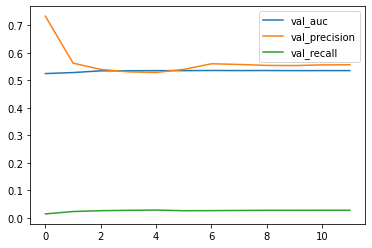

In [21]:
plt.plot(graph_history_pool_solo['val_auc'])
plt.plot(graph_history_pool_solo['val_precision'])
plt.plot(graph_history_pool_solo['val_recall'])
plt.legend(['val_auc', 'val_precision', 'val_recall'])

## Pooled Pooled

In [22]:
g, trs_features, ctc_features = to_dgl_graph(pooled_trs.copy(), pooled_ctc.copy(), label_field='is_alert_pooled')

C:\Users\GABRIE~1.OLY\AppData\Local\Temp/ipykernel_17372/2726447313.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trs[trs['right_bank_id']==False]['sample_weights']=0


In [23]:
g.ndata['train_mask'].numpy().sum(), g.ndata['val_mask'].numpy().sum()

(966718, 126641)

In [24]:
model_pool_pool = GCN_ACPR(g, trs_features, ctc_features, d_model, dff, n_layers, n_classes)
# model = GAT(g, d_model, n_layers, n_classes, num_heads)

model_pool_pool.soft_compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none'),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='none'),
    optimizer=tf.keras.optimizers.Adam(0.01, 1e-8),
#     metrics={'accuracy':tf.keras.metrics.SparseCategoricalAccuracy()}
    metrics={'accuracy':tf.keras.metrics.BinaryAccuracy(),
             'auc' : tf.keras.metrics.AUC(),
             'precision' : tf.keras.metrics.Precision(),
             'recall' : tf.keras.metrics.Recall(),
            },
    val_metrics={'accuracy':tf.keras.metrics.BinaryAccuracy(),
             'auc' : tf.keras.metrics.AUC(),
             'precision' : tf.keras.metrics.Precision(),
             'recall' : tf.keras.metrics.Recall(),
            }
)

graph_history_pool_pool = model_pool_pool.train(epochs=epochs,batch_size=batch_size, reduce_lr=reduce_lr, early_stopping=early_stopping)

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 : {'loss': 1.1581, 'accuracy': 0.8699, 'auc': 0.615, 'precision': 0.003, 'recall': 0.2007, 'lr': 0.01, 'val_loss': 0.0071842372, 'val_accuracy': 0.9991, 'val_auc': 0.7035, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 1:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 : {'loss': 0.0643, 'accuracy': 0.9768, 'auc': 0.7024, 'precision': 0.0122, 'recall': 0.2091, 'lr': 0.01, 'val_loss': 0.0059527913, 'val_accuracy': 0.9991, 'val_auc': 0.7035, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 2:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2 : {'loss': 0.0574, 'accuracy': 0.986, 'auc': 0.717, 'precision': 0.0232, 'recall': 0.2448, 'lr': 0.01, 'val_loss': 0.0055022193, 'val_accuracy': 0.9991, 'val_auc': 0.7035, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 3:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3 : {'loss': 0.0537, 'accuracy': 0.9898, 'auc': 0.7199, 'precision': 0.0336, 'recall': 0.2562, 'lr': 0.01, 'val_loss': 0.0052967225, 'val_accuracy': 0.9991, 'val_auc': 0.7034, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 4:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4 : {'loss': 0.0526, 'accuracy': 0.9919, 'auc': 0.7274, 'precision': 0.0438, 'recall': 0.2644, 'lr': 0.01, 'val_loss': 0.005190431, 'val_accuracy': 0.9991, 'val_auc': 0.7232, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 5:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5 : {'loss': 0.0516, 'accuracy': 0.9932, 'auc': 0.7454, 'precision': 0.0537, 'recall': 0.2678, 'lr': 0.01, 'val_loss': 0.005135096, 'val_accuracy': 0.9991, 'val_auc': 0.7352, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 6:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6 : {'loss': 0.0514, 'accuracy': 0.9941, 'auc': 0.7597, 'precision': 0.0632, 'recall': 0.2701, 'lr': 0.01, 'val_loss': 0.005101425, 'val_accuracy': 0.9991, 'val_auc': 0.7452, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 7:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7 : {'loss': 0.0513, 'accuracy': 0.9948, 'auc': 0.7723, 'precision': 0.0731, 'recall': 0.2728, 'lr': 0.01, 'val_loss': 0.0050803204, 'val_accuracy': 0.9991, 'val_auc': 0.753, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 8:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8 : {'loss': 0.051, 'accuracy': 0.9953, 'auc': 0.7813, 'precision': 0.0826, 'recall': 0.2752, 'lr': 0.01, 'val_loss': 0.005062895, 'val_accuracy': 0.9991, 'val_auc': 0.7603, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 9:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9 : {'loss': 0.0509, 'accuracy': 0.9957, 'auc': 0.7897, 'precision': 0.0919, 'recall': 0.2765, 'lr': 0.01, 'val_loss': 0.005058164, 'val_accuracy': 0.9991, 'val_auc': 0.7687, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10 : {'loss': 0.051, 'accuracy': 0.996, 'auc': 0.7952, 'precision': 0.1008, 'recall': 0.2776, 'lr': 0.01, 'val_loss': 0.0050562844, 'val_accuracy': 0.9991, 'val_auc': 0.7731, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 11:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11 : {'loss': 0.0507, 'accuracy': 0.9963, 'auc': 0.8014, 'precision': 0.1096, 'recall': 0.2782, 'lr': 0.01, 'val_loss': 0.0050642192, 'val_accuracy': 0.9991, 'val_auc': 0.7752, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 12:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12 : {'loss': 0.0507, 'accuracy': 0.9965, 'auc': 0.8058, 'precision': 0.1182, 'recall': 0.2788, 'lr': 0.01, 'val_loss': 0.0050509833, 'val_accuracy': 0.9991, 'val_auc': 0.7771, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 13:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13 : {'loss': 0.0508, 'accuracy': 0.9967, 'auc': 0.81, 'precision': 0.1265, 'recall': 0.2788, 'lr': 0.01, 'val_loss': 0.00507154, 'val_accuracy': 0.9991, 'val_auc': 0.7764, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 14:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14 : {'loss': 0.0506, 'accuracy': 0.9969, 'auc': 0.8126, 'precision': 0.1352, 'recall': 0.2806, 'lr': 0.01, 'val_loss': 0.005022902, 'val_accuracy': 0.9991, 'val_auc': 0.78, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 15:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15 : {'loss': 0.0505, 'accuracy': 0.997, 'auc': 0.816, 'precision': 0.143, 'recall': 0.2802, 'lr': 0.01, 'val_loss': 0.005051556, 'val_accuracy': 0.9991, 'val_auc': 0.7803, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 16:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16 : {'loss': 0.0505, 'accuracy': 0.9971, 'auc': 0.8181, 'precision': 0.1511, 'recall': 0.2808, 'lr': 0.01, 'val_loss': 0.0050543714, 'val_accuracy': 0.9991, 'val_auc': 0.7802, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 17:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17 : {'loss': 0.0506, 'accuracy': 0.9972, 'auc': 0.8202, 'precision': 0.1589, 'recall': 0.281, 'lr': 0.01, 'val_loss': 0.0050494396, 'val_accuracy': 0.9991, 'val_auc': 0.7817, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 18:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18 : {'loss': 0.0508, 'accuracy': 0.9973, 'auc': 0.8221, 'precision': 0.1669, 'recall': 0.2819, 'lr': 0.01, 'val_loss': 0.0050394298, 'val_accuracy': 0.9991, 'val_auc': 0.7847, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 19:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19 : {'loss': 0.0506, 'accuracy': 0.9974, 'auc': 0.8237, 'precision': 0.1746, 'recall': 0.2823, 'lr': 0.01, 'val_loss': 0.0050389715, 'val_accuracy': 0.9991, 'val_auc': 0.7828, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 20:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20 : {'loss': 0.0505, 'accuracy': 0.9975, 'auc': 0.8254, 'precision': 0.1819, 'recall': 0.2823, 'lr': 0.01, 'val_loss': 0.005036969, 'val_accuracy': 0.9991, 'val_auc': 0.7839, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 21:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21 : {'loss': 0.0508, 'accuracy': 0.9976, 'auc': 0.8263, 'precision': 0.1893, 'recall': 0.2827, 'lr': 0.01, 'val_loss': 0.00502059, 'val_accuracy': 0.9991, 'val_auc': 0.7872, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 22:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22 : {'loss': 0.0505, 'accuracy': 0.9977, 'auc': 0.8273, 'precision': 0.1963, 'recall': 0.2828, 'lr': 0.01, 'val_loss': 0.005027934, 'val_accuracy': 0.9991, 'val_auc': 0.7894, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 23:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23 : {'loss': 0.0506, 'accuracy': 0.9977, 'auc': 0.8288, 'precision': 0.2036, 'recall': 0.2832, 'lr': 0.01, 'val_loss': 0.0050476543, 'val_accuracy': 0.9991, 'val_auc': 0.7919, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24 : {'loss': 0.0504, 'accuracy': 0.9978, 'auc': 0.8297, 'precision': 0.2105, 'recall': 0.2834, 'lr': 0.01, 'val_loss': 0.005091377, 'val_accuracy': 0.9991, 'val_auc': 0.7915, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 25 : {'loss': 0.0506, 'accuracy': 0.9978, 'auc': 0.8304, 'precision': 0.2174, 'recall': 0.2836, 'lr': 0.01, 'val_loss': 0.005033769, 'val_accuracy': 0.9991, 'val_auc': 0.7918, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 26:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 26 : {'loss': 0.051, 'accuracy': 0.9979, 'auc': 0.831, 'precision': 0.224, 'recall': 0.2837, 'lr': 0.01, 'val_loss': 0.0050808717, 'val_accuracy': 0.9991, 'val_auc': 0.7956, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 27:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 27 : {'loss': 0.0506, 'accuracy': 0.9979, 'auc': 0.832, 'precision': 0.2305, 'recall': 0.2839, 'lr': 0.01, 'val_loss': 0.00502643, 'val_accuracy': 0.9991, 'val_auc': 0.7978, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 28:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 28 : {'loss': 0.0508, 'accuracy': 0.998, 'auc': 0.8327, 'precision': 0.2369, 'recall': 0.2838, 'lr': 0.01, 'val_loss': 0.0050184103, 'val_accuracy': 0.9991, 'val_auc': 0.7996, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 29:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 29 : {'loss': 0.0506, 'accuracy': 0.998, 'auc': 0.8334, 'precision': 0.2433, 'recall': 0.284, 'lr': 0.01, 'val_loss': 0.005041423, 'val_accuracy': 0.9991, 'val_auc': 0.8009, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 30 : {'loss': 0.0507, 'accuracy': 0.998, 'auc': 0.8338, 'precision': 0.2496, 'recall': 0.2842, 'lr': 0.01, 'val_loss': 0.0050075008, 'val_accuracy': 0.9991, 'val_auc': 0.8028, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 31:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 31 : {'loss': 0.0506, 'accuracy': 0.9981, 'auc': 0.8347, 'precision': 0.2558, 'recall': 0.2842, 'lr': 0.01, 'val_loss': 0.0050169392, 'val_accuracy': 0.9991, 'val_auc': 0.8031, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 32:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 32 : {'loss': 0.0505, 'accuracy': 0.9981, 'auc': 0.8351, 'precision': 0.2619, 'recall': 0.2844, 'lr': 0.01, 'val_loss': 0.005026612, 'val_accuracy': 0.9991, 'val_auc': 0.802, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 33:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 33 : {'loss': 0.0506, 'accuracy': 0.9981, 'auc': 0.8356, 'precision': 0.2679, 'recall': 0.2846, 'lr': 0.01, 'val_loss': 0.005003889, 'val_accuracy': 0.9991, 'val_auc': 0.8021, 'val_precision': 1.0, 'val_recall': 0.3121}
Reducing learning rate from 0.009999999776482582 to 0.0009999999776482583


Epoch 34:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 34 : {'loss': 0.0504, 'accuracy': 0.9982, 'auc': 0.8363, 'precision': 0.2737, 'recall': 0.2845, 'lr': 0.0009999999776482583, 'val_loss': 0.0049956394, 'val_accuracy': 0.9991, 'val_auc': 0.8031, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 35:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 35 : {'loss': 0.0502, 'accuracy': 0.9982, 'auc': 0.8368, 'precision': 0.2795, 'recall': 0.2849, 'lr': 0.0009999999776482583, 'val_loss': 0.004992427, 'val_accuracy': 0.9991, 'val_auc': 0.8042, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 36:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 36 : {'loss': 0.0505, 'accuracy': 0.9982, 'auc': 0.8379, 'precision': 0.285, 'recall': 0.2847, 'lr': 0.0009999999776482583, 'val_loss': 0.0049898303, 'val_accuracy': 0.9991, 'val_auc': 0.8051, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 37:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 37 : {'loss': 0.0504, 'accuracy': 0.9982, 'auc': 0.8389, 'precision': 0.2908, 'recall': 0.2849, 'lr': 0.0009999999776482583, 'val_loss': 0.004996021, 'val_accuracy': 0.9991, 'val_auc': 0.8057, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 38:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 38 : {'loss': 0.0502, 'accuracy': 0.9983, 'auc': 0.84, 'precision': 0.2961, 'recall': 0.2848, 'lr': 0.0009999999776482583, 'val_loss': 0.005008716, 'val_accuracy': 0.9991, 'val_auc': 0.8052, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 39:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 39 : {'loss': 0.0504, 'accuracy': 0.9983, 'auc': 0.8409, 'precision': 0.3017, 'recall': 0.285, 'lr': 0.0009999999776482583, 'val_loss': 0.005010687, 'val_accuracy': 0.9991, 'val_auc': 0.8042, 'val_precision': 1.0, 'val_recall': 0.3121}
Reducing learning rate from 0.0009999999776482583 to 9.999999776482583e-05


Epoch 40:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 40 : {'loss': 0.0502, 'accuracy': 0.9983, 'auc': 0.8408, 'precision': 0.307, 'recall': 0.2851, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049893716, 'val_accuracy': 0.9991, 'val_auc': 0.8045, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 41:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 41 : {'loss': 0.0502, 'accuracy': 0.9983, 'auc': 0.8413, 'precision': 0.3122, 'recall': 0.2851, 'lr': 9.999999776482583e-05, 'val_loss': 0.004985279, 'val_accuracy': 0.9991, 'val_auc': 0.8051, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 42:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 42 : {'loss': 0.0499, 'accuracy': 0.9983, 'auc': 0.8423, 'precision': 0.3175, 'recall': 0.2853, 'lr': 9.999999776482583e-05, 'val_loss': 0.004986422, 'val_accuracy': 0.9991, 'val_auc': 0.8057, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 43:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 43 : {'loss': 0.05, 'accuracy': 0.9984, 'auc': 0.8432, 'precision': 0.3225, 'recall': 0.2852, 'lr': 9.999999776482583e-05, 'val_loss': 0.004986433, 'val_accuracy': 0.9991, 'val_auc': 0.8063, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 44:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 44 : {'loss': 0.0502, 'accuracy': 0.9984, 'auc': 0.844, 'precision': 0.3275, 'recall': 0.2853, 'lr': 9.999999776482583e-05, 'val_loss': 0.004988962, 'val_accuracy': 0.9991, 'val_auc': 0.8069, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 45:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 45 : {'loss': 0.0501, 'accuracy': 0.9984, 'auc': 0.8448, 'precision': 0.3324, 'recall': 0.2852, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049867374, 'val_accuracy': 0.9991, 'val_auc': 0.8075, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 46:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 46 : {'loss': 0.0503, 'accuracy': 0.9984, 'auc': 0.8455, 'precision': 0.3374, 'recall': 0.2855, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049887956, 'val_accuracy': 0.9991, 'val_auc': 0.808, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 47:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 47 : {'loss': 0.05, 'accuracy': 0.9984, 'auc': 0.8462, 'precision': 0.3421, 'recall': 0.2855, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049870624, 'val_accuracy': 0.9991, 'val_auc': 0.8085, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 48:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 48 : {'loss': 0.0502, 'accuracy': 0.9984, 'auc': 0.847, 'precision': 0.347, 'recall': 0.2856, 'lr': 9.999999776482583e-05, 'val_loss': 0.00498751, 'val_accuracy': 0.9991, 'val_auc': 0.809, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 49:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 49 : {'loss': 0.0498, 'accuracy': 0.9984, 'auc': 0.8477, 'precision': 0.3515, 'recall': 0.2855, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049891304, 'val_accuracy': 0.9991, 'val_auc': 0.8094, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 50:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 50 : {'loss': 0.0501, 'accuracy': 0.9985, 'auc': 0.8483, 'precision': 0.3561, 'recall': 0.2856, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049885097, 'val_accuracy': 0.9991, 'val_auc': 0.8099, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 51:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 51 : {'loss': 0.0499, 'accuracy': 0.9985, 'auc': 0.8489, 'precision': 0.3607, 'recall': 0.2857, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049872384, 'val_accuracy': 0.9991, 'val_auc': 0.8103, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 52:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 52 : {'loss': 0.0502, 'accuracy': 0.9985, 'auc': 0.8495, 'precision': 0.3652, 'recall': 0.2857, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049892752, 'val_accuracy': 0.9991, 'val_auc': 0.8108, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 53:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 53 : {'loss': 0.0499, 'accuracy': 0.9985, 'auc': 0.85, 'precision': 0.3695, 'recall': 0.2857, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049881544, 'val_accuracy': 0.9991, 'val_auc': 0.8111, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 54:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 54 : {'loss': 0.0499, 'accuracy': 0.9985, 'auc': 0.8504, 'precision': 0.3739, 'recall': 0.2858, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049887854, 'val_accuracy': 0.9991, 'val_auc': 0.8115, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 55:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 55 : {'loss': 0.05, 'accuracy': 0.9985, 'auc': 0.8509, 'precision': 0.3781, 'recall': 0.2857, 'lr': 9.999999776482583e-05, 'val_loss': 0.0049891123, 'val_accuracy': 0.9991, 'val_auc': 0.8119, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 56:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 56 : {'loss': 0.05, 'accuracy': 0.9985, 'auc': 0.8513, 'precision': 0.3825, 'recall': 0.286, 'lr': 9.999999776482583e-05, 'val_loss': 0.004988968, 'val_accuracy': 0.9991, 'val_auc': 0.8119, 'val_precision': 1.0, 'val_recall': 0.3121}
Reducing learning rate from 9.999999776482583e-05 to 9.999999776482583e-06


Epoch 57:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 57 : {'loss': 0.0498, 'accuracy': 0.9985, 'auc': 0.8517, 'precision': 0.3866, 'recall': 0.2859, 'lr': 9.999999776482583e-06, 'val_loss': 0.0049890103, 'val_accuracy': 0.9991, 'val_auc': 0.812, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 58:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 58 : {'loss': 0.0504, 'accuracy': 0.9985, 'auc': 0.8521, 'precision': 0.3908, 'recall': 0.286, 'lr': 9.999999776482583e-06, 'val_loss': 0.004989229, 'val_accuracy': 0.9991, 'val_auc': 0.8121, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 59:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 59 : {'loss': 0.0501, 'accuracy': 0.9986, 'auc': 0.8524, 'precision': 0.3947, 'recall': 0.2859, 'lr': 9.999999776482583e-06, 'val_loss': 0.0049887705, 'val_accuracy': 0.9991, 'val_auc': 0.8121, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 60:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 60 : {'loss': 0.0499, 'accuracy': 0.9986, 'auc': 0.8527, 'precision': 0.3987, 'recall': 0.2859, 'lr': 9.999999776482583e-06, 'val_loss': 0.004988716, 'val_accuracy': 0.9991, 'val_auc': 0.8122, 'val_precision': 1.0, 'val_recall': 0.3121}
Reducing learning rate from 9.999999776482583e-06 to 9.999999776482584e-07


Epoch 61:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 61 : {'loss': 0.05, 'accuracy': 0.9986, 'auc': 0.8531, 'precision': 0.4027, 'recall': 0.2861, 'lr': 9.999999776482584e-07, 'val_loss': 0.0049887784, 'val_accuracy': 0.9991, 'val_auc': 0.8123, 'val_precision': 1.0, 'val_recall': 0.3121}


Epoch 62:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 62 : {'loss': 0.0499, 'accuracy': 0.9986, 'auc': 0.8534, 'precision': 0.4066, 'recall': 0.2861, 'lr': 9.999999776482584e-07, 'val_loss': 0.0049887663, 'val_accuracy': 0.9991, 'val_auc': 0.8123, 'val_precision': 1.0, 'val_recall': 0.3121}
***************************************************************************


In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

model = model_pool_pool

train_indices, val_indices, test_indices=model_solo_solo.split_indices()
labels=model.g.ndata['label'].numpy()
val_labels=labels[test_indices]
val_logits=model.call(np.arange(len(val_indices))).numpy()

precision, recall, thresholds = precision_recall_curve(val_labels, val_logits)
fpr, tpr, threshold = roc_curve(val_labels, val_logits)
roc_auc = metrics.auc(fpr, tpr)

f1_score = 2*precision*recall/(precision + recall)

ind=np.argmax(f1_score)

print({
    'roc_auc_score':roc_auc_score(val_labels, val_logits),
    'precision':precsion[ind],
    'recall':recall[ind],
    'f1_score':f1_score[ind],
})

index = np.arange(len(precision))
t = 0.9*recall.max()
min_index = index[recall >= t]
print({
    'max_recall':recall.max(),
    '90 max recall':t,
    'precision_at_recall':precision[min_index],
    'f1_at_recall':f1_score[min_index]
})

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
len(labels)

1093359

In [26]:
train_indices, val_indices, test_indices=model_pool_pool.split_indices()
labels=model_pool_pool.g.ndata['label'].numpy()

logits=model_pool_pool.call(np.arange(len(labels))).numpy()
val_labels=labels[test_indices]

# plt.hist(val_logits)
tf.keras.metrics.AUC()(val_labels, logits[test_indices])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8159376>

(array([1.2655e+05, 3.1000e+01, 1.1000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9000e+01]),
 array([1.6614881e-07, 9.9999450e-02, 1.9999874e-01, 2.9999802e-01,
        3.9999732e-01, 4.9999660e-01, 5.9999591e-01, 6.9999516e-01,
        7.9999447e-01, 8.9999372e-01, 9.9999303e-01], dtype=float32),
 <BarContainer object of 10 artists>)

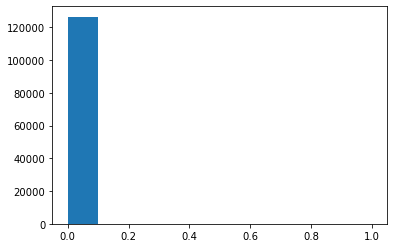

In [27]:
plt.hist(logits[test_indices])

In [28]:
tf.keras.metrics.AUC()(val_labels, logits[test_indices])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8159376>

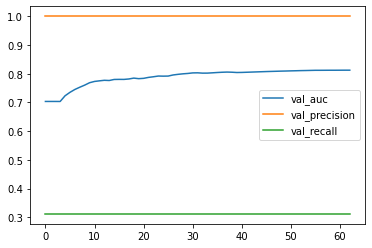

In [29]:
plt.plot(graph_history_pool_pool['val_auc'])
plt.plot(graph_history_pool_pool['val_precision'])
plt.plot(graph_history_pool_pool['val_recall'])
plt.legend(['val_auc', 'val_precision', 'val_recall'])

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


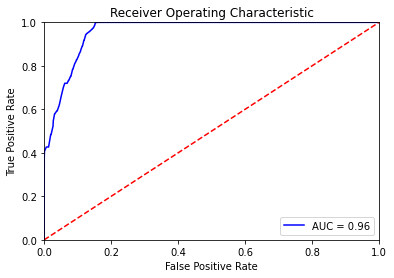

In [30]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(val_labels, logits[test_indices])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
